In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading in hand charted match data
match_info=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/CHARTING M MATCHES WORK.xlsx')
return_outcomes=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-ReturnOutcomes WORK.xlsx')
net_points=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-NetPoints WORK.xlsx')
overview=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-Overview WORK.xlsx')
rally_=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-Rally WORK.xlsx')
serve_influence=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-ServeInfluence WORK.xlsx')
shot_direction=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-ShotDirection WORK.xlsx')
shot_types=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-ShotTypes WORK.xlsx')
serve_volley=pd.read_excel('/content/drive/MyDrive/MATH 642 Final Project/Data/Charting Data/charting-m-stats-SnV WORK.xlsx')

In [ ]:
#Cleaning
dfs=[match_info,return_outcomes,net_points,overview,rally_,serve_influence,shot_direction,shot_types,serve_volley]
for i,df in enumerate(dfs):
  dfs[i]=dfs[i].dropna()

In [ ]:
#Removing set based statistics and keeping only total statistics for each match
return_outcomes.head()
return_outcomes_1=return_outcomes.loc[return_outcomes['row']=='Total']
return_outcomes_1=return_outcomes_1.drop(columns=['row'])

#net_points is already totaled

overview_1=overview.loc[overview['set']=='Total']
overview_1=overview_1.drop(columns=['set'])

rally_1=rally_.loc[rally_['row']=='Total']
rally_1=rally_1.drop(columns=['row'])

#serve influence

shot_direction_1=shot_direction.loc[shot_direction['row']=='Total']
shot_direction_1=shot_direction_1.drop(columns='row')

shot_types_1=shot_types.loc[shot_types['row']=='Total']
shot_types_1=shot_types_1.drop(columns=['row'])

serve_volley_1=serve_volley.loc[serve_volley['row'].isin(['SnV','nonSnV'])]

In [ ]:
#Messing with shots column to get rid of some unnecessary statistics (these metrics are already explained in other columns or are not relevant to anything 
#I'm currently interested in)
shot_types_1=shot_types_1.drop(columns=['winners','serve_return','unforced','shots_in_pts_lost'])

In [ ]:
#Joining on multiple columns to get one dataframe with two rows for each match where each row contains player 1 or player 2 stats
joined=match_info.merge(overview_1,on='match_id')
joined_1=joined.merge(shot_direction_1,on=['match_id','player'])
joined_2=joined_1.merge(shot_types_1,on=['match_id','player'])

In [ ]:
#Creating different dataframes to make joining on keys more match_id and player a little easier
rally_1_p1=rally_1[['match_id','pts','pl1_won']]
rally_1_p2=rally_1[['match_id','pts','pl2_won']]

rally_1_p1['player']=np.zeros(rally_1_p1.shape[0],dtype=int)+1
rally_1_p2['player']=np.ones(rally_1_p2.shape[0],dtype=int)+1

rally_1_p1=rally_1_p1.rename(columns={'pl1_won':'pts_won'})
rally_1_p2=rally_1_p2.rename(columns={'pl2_won':'pts_won'})

rally_2=pd.concat([rally_1_p1,rally_1_p2])

In [ ]:
#Joining master dataset with newly created dataset
joined_3=joined_2.merge(rally_2,on=['match_id','player'])

In [ ]:
#Changing a column name to avoid ambiguity
joined_3=joined_3.rename(columns={'shots':'total_shots'})

In [ ]:
#Cleaning serve and volley dataset
snv_finalized=serve_volley_1.loc[serve_volley_1['row']=='SnV']
snv_finalized=snv_finalized.drop(columns=['row','aces','unret','return_forced','net_winner','induced_forced','net_unforced','passed_at_net','passing_shot_induced_forced','total_shots'])
snv_finalized=snv_finalized.rename(columns={'pts_won':'snv_pts_won'})

In [ ]:
#Cleaning net points dataset
net_points_1=net_points.loc[net_points['row']=='NetPoints']
net_points_1=net_points_1.drop(columns=['row','net_winner','induced_forced','net_unforced','passed_at_net','passing_shot_induced_forced','total_shots'])
net_points_1=net_points_1.rename(columns={'pts_won':'net_pts_won'})

In [ ]:
#Joining net_points to existing master df
joined_4=joined_3.merge(net_points_1,on=['match_id','player'])

In [ ]:
#Joining 
joined_5=joined_4.merge(snv_finalized,on=['match_id','player'])

In [ ]:
#Here, we can see that we lose almost 2000 matches when joinining the two dataframes. This is because many matches are missing the serve and volley
#percentage column. We will work on imputing this data later in the notebook
print(joined_4.shape)
print(joined_5.shape)

(4804, 47)
(3076, 49)


In [ ]:
#Removing more unnecessary columns
joined_5=joined_5.drop(columns=joined_5.columns[3:13])
joined_5=joined_5.drop(columns=['Final TB?','Charted by','Best of'])

joined_4=joined_4.drop(columns=joined_4.columns[3:13])
joined_4=joined_4.drop(columns=['Final TB?','Charted by','Best of'])

In [ ]:
#Getting rid of the irrelevant player in each row and making a new "Player Name" row in the dataframe
joined_5['Player_Name']=joined_5.apply(lambda row: row['Player 1'] if row['player']==1 else row['Player 2'],axis=1)
joined_4['Player_Name']=joined_4.apply(lambda row: row['Player 1'] if row['player']==1 else row['Player 2'],axis=1)

In [ ]:
#Moving Player_Name to front
cols=joined_5.columns.tolist()
cols.insert(1,cols[-1])
cols.pop(-1)
joined_5=joined_5[cols]

cols1=joined_4.columns.tolist()
cols1.insert(1,cols1[-1])
cols1.pop(-1)
joined_4=joined_4[cols1]

In [ ]:
#Dropping Player 1 and Player 2 columns from joined_5 (leaving player # column in case I want to add more data later)
joined_5=joined_5.drop(columns=['Player 1','Player 2'])
joined_4=joined_4.drop(columns=['Player 1','Player 2'])

In [ ]:
#Creating useful columns for analysis (mostly percentages)
joined_5['first_serve_percen']=joined_5['first_in']/joined_5['serve_pts']
joined_5['pt_ending_shot_percen']=joined_5['pt_ending']/joined_5['total_shots']
joined_5['av_shots_per_pt_won']=joined_5['shots_in_pts_won']/joined_5['pts_won']
joined_5['first_serve_pts_won_percen']=joined_5['first_won']/joined_5['first_in']
joined_5['second_serve_pts_won_percen']=joined_5['second_won']/joined_5['second_in']
joined_5['net_points_percen']=joined_5['net_pts']/joined_5['pts']
joined_5['net_points_won_percen']=joined_5['net_pts_won']/joined_5['net_pts']
joined_5['snv_percen']=joined_5['snv_pts']/joined_5['serve_pts']
joined_5['ace_percen']=joined_5['aces']/joined_5['serve_pts']
joined_5['snv_pts_won_percen']=joined_5['snv_pts_won']/joined_5['snv_pts']
joined_5['return_pts_won_percen']=joined_5['return_pts_won']/joined_5['return_pts']
joined_5['percen_unsafe_shots_made']=joined_5[['down_the_line','inside_out','inside_in']].sum(axis=1)/joined_5[['down_the_line','inside_out','inside_in','crosscourt','down_middle']].sum(axis=1)
joined_5['break_pts_percen']=joined_5['bk_pts']/joined_5['serve_pts']
joined_5['percen_pts_lost_from_unforced']=joined_5['unforced']/(joined_5['pts']-joined_5['pts_won'])
joined_5['percen_pts_won_from_winner_FE']=(joined_5['winners']+joined_5['induced_forced'])/joined_5['pts_won']


joined_4['first_serve_percen']=joined_4['first_in']/joined_4['serve_pts']
joined_4['pt_ending_shot_percen']=joined_4['pt_ending']/joined_4['total_shots']
joined_4['av_shots_per_pt_won']=joined_4['shots_in_pts_won']/joined_4['pts_won']
joined_4['first_serve_pts_won_percen']=joined_4['first_won']/joined_4['first_in']
joined_4['second_serve_pts_won_percen']=joined_4['second_won']/joined_4['second_in']
joined_4['net_points_percen']=joined_4['net_pts']/joined_4['pts']
joined_4['net_points_won_percen']=joined_4['net_pts_won']/joined_4['net_pts']
joined_4['ace_percen']=joined_4['aces']/joined_4['serve_pts']
joined_4['return_pts_won_percen']=joined_4['return_pts_won']/joined_4['return_pts']
joined_4['percen_unsafe_shots_made']=joined_4[['down_the_line','inside_out','inside_in']].sum(axis=1)/joined_4[['down_the_line','inside_out','inside_in','crosscourt','down_middle']].sum(axis=1)
joined_4['break_pts_percen']=joined_4['bk_pts']/joined_4['serve_pts']
joined_4['percen_pts_lost_from_unforced']=joined_4['unforced']/(joined_4['pts']-joined_4['pts_won'])
joined_4['percen_pts_won_from_winner_FE']=(joined_4['winners']+joined_4['induced_forced'])/joined_4['pts_won']

In [ ]:
#Creating a new dataset contianing mostly only useful columns
cluster_set_1=joined_5.drop(columns=joined_5.columns[3:34])
cluster_set_1=cluster_set_1.drop(columns=['snv_pts_won'])
cluster_set_1=cluster_set_1.drop(columns=['snv_pts_won_percen'])

missing_snv=joined_4.drop(columns=joined_4.columns[3:33])

In [ ]:
#Grouping relevant columns by player and finding the mean for each player
cluster_set_1_grouped=cluster_set_1.groupby('Player_Name').mean().reset_index()
cluster_set_1_grouped=cluster_set_1_grouped.drop(columns=['player'])

#Doing the same for the dataset containing players that are not in the original dataset and missing serve and volley
#percentage
missing_snv=missing_snv.loc[~missing_snv['Player_Name'].isin(cluster_set_1_grouped['Player_Name'].unique())]
missing_snv_grouped=missing_snv.groupby('Player_Name').mean().reset_index()
missing_snv_grouped=missing_snv_grouped.drop(columns=['player'])

In [ ]:
#Comparing two very differnet stylistic players to make sure the data makes sense
cluster_set_1_grouped.loc[cluster_set_1_grouped['Player_Name'].isin(['David Ferrer','John Isner'])]

,Player_Name,first_serve_percen,pt_ending_shot_percen,av_shots_per_pt_won,first_serve_pts_won_percen,second_serve_pts_won_percen,net_points_percen,net_points_won_percen,snv_percen,ace_percen,return_pts_won_percen,percen_unsafe_shots_made,break_pts_percen,percen_pts_lost_from_unforced,percen_pts_won_from_winner_FE
84,David Ferrer,0.662788,0.115511,2.351317,0.599008,0.459102,0.124233,0.653495,0.013899,0.001795,0.297954,0.317681,0.106321,0.271738,0.267915
194,John Isner,0.695712,0.309722,0.929733,0.761807,0.532544,0.163428,0.653709,0.134558,0.190781,0.262911,0.407395,0.061391,0.348543,0.561044


In [ ]:
cluster_set_1_grouped

,Player_Name,first_serve_percen,pt_ending_shot_percen,av_shots_per_pt_won,first_serve_pts_won_percen,second_serve_pts_won_percen,net_points_percen,net_points_won_percen,snv_percen,ace_percen,return_pts_won_percen,percen_unsafe_shots_made,break_pts_percen,percen_pts_lost_from_unforced,percen_pts_won_from_winner_FE
0,Aaron Krickstein,0.518601,0.146974,1.802474,0.784708,0.384331,0.146346,0.672269,0.049107,0.049107,0.329849,0.305124,0.078869,0.276502,0.373196
1,Adam Pavlasek,0.659574,0.205000,1.875000,0.709677,0.875000,0.299065,0.656250,0.063830,0.085106,0.466667,0.380597,0.000000,0.348837,0.468750
2,Adrian Mannarino,0.692490,0.146700,2.321746,0.642301,0.494219,0.090480,0.530370,0.030402,0.051280,0.336418,0.182351,0.092687,0.377884,0.376825
3,Adriano Panatta,0.627273,0.220455,1.760000,0.536232,0.414634,0.469828,0.458716,0.163636,0.018182,0.377049,0.187970,0.145455,0.318182,0.600000
4,Agustin Calleri,0.535714,0.255051,1.912500,0.711111,0.435897,0.278409,0.571429,0.011905,0.047619,0.336957,0.305755,0.130952,0.562500,0.712500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,Yuichi Ito,0.638889,0.162791,2.035714,0.434783,0.307692,0.160494,0.538462,0.055556,0.027778,0.311111,0.214286,0.166667,0.339623,0.464286
407,Yuichi Sugita,0.737705,0.252101,1.280000,0.644444,0.625000,0.081081,0.777778,0.016393,0.016393,0.220000,0.318681,0.098361,0.147541,0.460000
408,Yuki Bhambri,0.764706,0.277778,1.060000,0.846154,0.750000,0.202899,0.714286,0.205882,0.058824,0.628571,0.351351,0.000000,0.210526,0.380000
409,Ze Zhang,0.734087,0.252677,1.955905,0.683091,0.414530,0.126902,0.807143,0.056712,0.098643,0.385730,0.318970,0.144193,0.572368,0.559348


In [ ]:
missing_snv_grouped

,Player_Name,first_serve_percen,pt_ending_shot_percen,av_shots_per_pt_won,first_serve_pts_won_percen,second_serve_pts_won_percen,net_points_percen,net_points_won_percen,ace_percen,return_pts_won_percen,percen_unsafe_shots_made,break_pts_percen,percen_pts_lost_from_unforced,percen_pts_won_from_winner_FE
0,Adrien Bossel,0.547619,0.267857,0.884615,0.608696,0.210526,0.128205,0.400000,0.023810,0.222222,0.197368,0.190476,0.365385,0.500000
1,Agustin Velotti,0.488889,0.122995,1.696970,0.909091,0.521739,0.046729,0.800000,0.088889,0.548387,0.300752,0.044444,0.341463,0.272727
2,Akira Santillan,0.611111,0.207101,1.421875,0.757576,0.428571,0.130841,0.714286,0.111111,0.566038,0.276786,0.092593,0.581395,0.343750
3,Albert Montanes,0.564693,0.173044,2.080770,0.577973,0.293103,0.041498,0.755556,0.034722,0.328449,0.403380,0.183480,0.381690,0.495218
4,Albert Ramos,0.617037,0.160801,2.428771,0.644304,0.468004,0.073283,0.611667,0.014445,0.328991,0.233960,0.108229,0.363550,0.416414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Yannick Maden,0.595332,0.148291,2.469223,0.666822,0.522222,0.102909,0.747826,0.026142,0.487371,0.225806,0.110424,0.358522,0.360330
136,Yannick Mertens,0.727273,0.200282,1.739860,0.638889,0.570175,0.041952,0.666667,0.031313,0.386871,0.123328,0.076768,0.376088,0.321212
137,Yasutaka Uchiyama,0.600000,0.207254,1.022222,0.740741,0.500000,0.054348,0.600000,0.133333,0.340426,0.358779,0.100000,0.287234,0.344444
138,Yoshihito Nishioka,0.640173,0.158007,2.046733,0.669735,0.569126,0.081038,0.708822,0.023859,0.372472,0.252064,0.094926,0.238305,0.401724


In [ ]:
#Checking the correlation matrix to see which columns may be correlated
cluster_set_1_grouped.corr()

#Here, we can see that pt_ending_shot_percen, net_points_percen, and av_shots_per_pt_won are all correlated with snv_percen, where pt_ending_shot_percen 
#is very positively correlated with snv_percen.

#Since this data is roughly incomplete (many potential rows are missing serve and volley statistics) we are interested in predicting snv_percen based based 
#on some of the other features in this dataset. This not only helps us get more data, but also provides insight into the number of times we can expect a 
#player to serve and volley based on statistics we already have. This can be of use to players preparing before matches that may not have access to 
#detailed data

,first_serve_percen,pt_ending_shot_percen,av_shots_per_pt_won,first_serve_pts_won_percen,second_serve_pts_won_percen,net_points_percen,net_points_won_percen,snv_percen,ace_percen,return_pts_won_percen,percen_unsafe_shots_made,break_pts_percen,percen_pts_lost_from_unforced,percen_pts_won_from_winner_FE
first_serve_percen,1.000000,-0.071620,0.022561,-0.038694,0.007826,-0.063378,0.117311,-0.043694,-0.035194,0.065614,0.008678,-0.123857,-0.094702,-0.046586
pt_ending_shot_percen,-0.071620,1.000000,-0.678369,0.308221,0.101058,0.449785,0.036281,0.533151,0.360387,-0.193170,0.348103,-0.227029,-0.057768,0.513827
av_shots_per_pt_won,0.022561,-0.678369,1.000000,-0.359448,-0.064533,-0.257866,0.002977,-0.416041,-0.470788,0.382363,-0.212628,0.244229,0.375580,-0.137140
first_serve_pts_won_percen,-0.038694,0.308221,-0.359448,1.000000,0.385429,0.074874,0.449480,0.123565,0.562538,0.155843,0.130559,-0.731248,-0.170251,0.226105
second_serve_pts_won_percen,0.007826,0.101058,-0.064533,0.385429,1.000000,-0.026951,0.287861,-0.015398,0.193725,0.345029,0.032912,-0.589494,-0.126685,-0.016107
net_points_percen,-0.063378,0.449785,-0.257866,0.074874,-0.026951,1.000000,-0.165048,0.908304,0.128968,-0.093570,0.072260,-0.020047,-0.309884,0.392451
net_points_won_percen,0.117311,0.036281,0.002977,0.449480,0.287861,-0.165048,1.000000,-0.131866,0.030229,0.249747,0.048192,-0.353949,0.015054,0.045904
snv_percen,-0.043694,0.533151,-0.416041,0.123565,-0.015398,0.908304,-0.131866,1.000000,0.198734,-0.166499,0.098117,-0.051630,-0.399840,0.307174
ace_percen,-0.035194,0.360387,-0.470788,0.562538,0.193725,0.128968,0.030229,0.198734,1.000000,-0.134128,0.112513,-0.365677,-0.115611,0.407162
return_pts_won_percen,0.065614,-0.193170,0.382363,0.155843,0.345029,-0.093570,0.249747,-0.166499,-0.134128,1.000000,-0.108479,-0.223454,0.228700,-0.113217


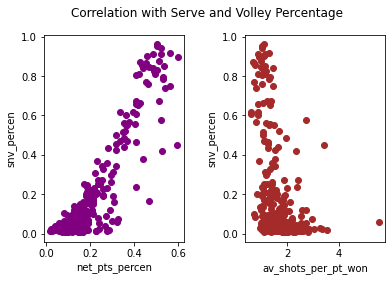

In [ ]:
#Here, we examine a plot of snv_percen vs. net_points_percen
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
fig.tight_layout(pad=3)
axs[0].scatter(cluster_set_1_grouped['net_points_percen'],cluster_set_1_grouped['snv_percen'],color='purple')
axs[1].scatter(cluster_set_1_grouped['av_shots_per_pt_won'],cluster_set_1_grouped['snv_percen'],color='brown')
fig.suptitle('Correlation with Serve and Volley Percentage')
axs[0].set_ylabel('snv_percen')
axs[0].set_xlabel('net_pts_percen')
axs[1].set_ylabel('snv_percen')
axs[1].set_xlabel('av_shots_per_pt_won')
plt.show()

In [ ]:
#Since some of the data is missing, we will use a couple techniques to attempt to impute serve and volley percentage for the missing samples. The first
#technique we will use is linear regression using LASSO for feature selection
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [ ]:
#Creating matrices from dataframes 
X=cluster_set_1_grouped.loc[:,~cluster_set_1_grouped.columns.isin(['Player_Name','snv_percen'])].to_numpy()
Y=cluster_set_1_grouped['snv_percen'].to_numpy()#.reshape((len(cluster_set_1_grouped['snv_percen']),1))

In [ ]:
from sklearn.model_selection import train_test_split
#Creating train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [ ]:
from scipy.special import logit
#Since the dependent variable in this case is a percentage, we use the logit function to map the probabilities to the real line to hopefully avoid
#negative numbers as predictions
Y_train_logit=logit(Y_train)
Y_test_logit=logit(Y_test)

In [ ]:
#Creating a large range of alphas to find the general region where the best alpha lies
alphas=np.arange(.0001,100000,5)

In [ ]:
#Using cross validation to select the best tuning paramater for the additional constraint on the coefficients of the model
lasreg_cv=LassoCV(alphas=alphas)
lasreg_cv.fit(X_train,Y_train_logit)

#Optimal alpha
print(lasreg_cv.alpha_)

0.0001


In [ ]:
#Seems like the optimal alpha is pretty small, so we rerun with a smaller range of values
alphas=np.arange(.00001,.001,.000001)
lasreg_cv=LassoCV(alphas=alphas)
lasreg_cv.fit(X_train,Y_train_logit)

#Optimal alpha
print(lasreg_cv.alpha_)

0.0004850000000000003


In [ ]:
#Creating new model with best alpha
lasreg=Lasso(alpha=lasreg_cv.alpha_)
lasreg.fit(X_train,Y_train_logit)
preds=lasreg.predict(X_test)
score=lasreg.score(X_test,Y_test_logit)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.special import expit
#Here, we can see that the R^2 is very close to one, so we are confident our model generalizes well to the testing data
print(f'The R^2 is {score}')

#MSE for training set
y_pred_train=lasreg.predict(X_train)
print(f'The train MSE is {mean_squared_error(Y_train_logit,y_pred_train)}')

#MSE for testing set
y_pred_test=lasreg.predict(X_test)
print(f'The test MSE is {mean_squared_error(Y_test_logit,y_pred_test)}')

#MAE for training set after transforming train targets from real #s back to percentages using a sigmoid function
y_pred_train_percen=expit(y_pred_train)
print(f'The transformed train MAE is {mean_absolute_error(Y_train,y_pred_train_percen)}')

#MAE for test set after transforming test targets from real #s back to percentages using a sigmoid function
y_pred_test_percen=expit(y_pred_test)
print(f'The transformed test MAE is {mean_absolute_error(Y_test,y_pred_test_percen)}')

#Model Coefficients
print(lasreg.coef_)



The R^2 is 0.8651564775441706
The train MSE is 0.420920990175293
The test MSE is 0.45497675609781346
The transformed train MAE is 0.037698697701312435
The transformed test MAE is 0.03382013343441128
[ 0.08309101  4.66193533 -0.21968443 -1.39301803 -0.70978269 11.13327031
  0.56023767  4.99555087  0.2179977   0.          0.         -1.96002061
 -3.00300557]


In [ ]:
#Next, we use the model above to generate predictions for the rows that have missing data. This part requires the missing_snv_grouped dataset created above
missing_snv_grouped=missing_snv_grouped.dropna()
missing_snv_X=missing_snv_grouped.iloc[:,1:].to_numpy()
snv_preds=lasreg.predict(missing_snv_X)

#Changing model predictions from real numbers to percentages
snv_preds=expit(snv_preds)

In [ ]:
#Adding snv_percen to dataframe missing the column
missing_snv_grouped['snv_percen']=snv_preds

In [ ]:
#Checking shapes before concatenating
print(missing_snv_grouped.shape)
print(cluster_set_1_grouped.shape)

#Concatenating dataset with imputed values to dataset without missing values
full_set=pd.concat([cluster_set_1_grouped,missing_snv_grouped])

(138, 15)
(411, 15)


In [ ]:
#Z scaling data before performing PCA for dimensionality reduction
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

scaler.fit(full_set[['pt_ending_shot_percen','av_shots_per_pt_won','first_serve_pts_won_percen','snv_percen','percen_pts_won_from_winner_FE','break_pts_percen']])

scaled_grouped=scaler.transform(full_set[['pt_ending_shot_percen','av_shots_per_pt_won','first_serve_pts_won_percen','snv_percen','percen_pts_won_from_winner_FE','break_pts_percen']])

In [ ]:
from sklearn.decomposition import PCA
#Finding components that preserve 82% of the variance in the original dataset
pca=PCA(.82)

#Projecting the data onto these components
scaled_grouped_vecs=pca.fit_transform(scaled_grouped)

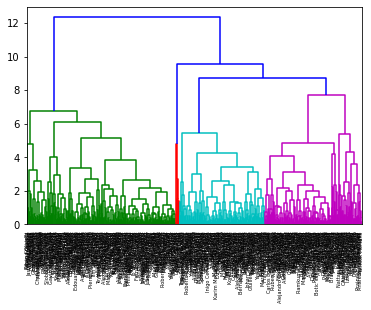

In [ ]:
#Clustering projected data and creating dendrogram from hierarchical clustering using complete distance measure
from scipy.cluster.hierarchy import dendrogram, linkage
Z=linkage(scaled_grouped_vecs,'complete')
dn=dendrogram(Z,labels=full_set['Player_Name'].to_numpy())

In [ ]:
from scipy.cluster.hierarchy import cut_tree

complete_clusters=cut_tree(Z,height=8)

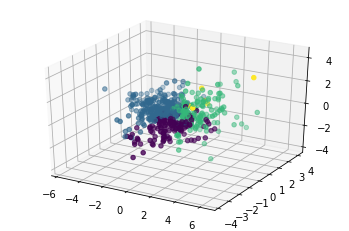

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(scaled_grouped_vecs[:,0],scaled_grouped_vecs[:,1],scaled_grouped_vecs[:,2],c=complete_clusters)

In [ ]:
#Taking a look at the clusters each player belonged to
clusters=pd.DataFrame()
clusters['Player_Name']=full_set['Player_Name']
clusters['Group']=complete_clusters

In [ ]:
#Below are some players that historically like to serve fast and shorten points. We can see that they have all been clustered into the same group.
clusters.loc[clusters['Player_Name'].isin(['John Isner','Reilly Opelka','Ivo Karlovic','Roger Federer','Maxime Cressy'])]

,Player_Name,Group
161,Ivo Karlovic,1
194,John Isner,1
270,Maxime Cressy,1
326,Reilly Opelka,1
336,Roger Federer,1


In [ ]:
#The goal of this project is to create a model that classifies amateur players into playstyle related categories based on their match statistics.
#Next steps include more experimentation with clustering techniques and the addition of a labeled dataset and some supervised classification methods